<a href="https://colab.research.google.com/github/OmarShafie/HBKU_Projects/blob/master/Fawaed_bio_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Feb 14 20:15:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install transformers
!git clone https://github.com/aub-mind/arabert
!pip install pyarabic
!pip install farasapy
!pip install arabic_reshaper
!pip install python-bidi
!pip install lime

fatal: destination path 'arabert' already exists and is not an empty directory.


In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import ast

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

In [ ]:
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

### Data Import

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
dataset_directory = 'gdrive/MyDrive/HBKU/Research/datasets/tutorial'
path_bio_tagged_train = dataset_directory + '/bio_tagged_train.csv'
path_bio_tagged_test  = dataset_directory + '/bio_tagged_test.csv'

df_bio_tagged_train = pd.read_csv(path_bio_tagged_train, header=0)
df_bio_tagged_test = pd.read_csv(path_bio_tagged_test, header=0)

path_sen_tagged_train = dataset_directory + '/sen_tagged_train.csv'
path_sen_tagged_test  = dataset_directory + '/sen_tagged_test.csv'

df_sen_tagged_train = pd.read_csv(path_sen_tagged_train, header=0)
df_sen_tagged_test = pd.read_csv(path_sen_tagged_test, header=0)

df_sen_tagged_train.tail()

,Unnamed: 0,text,الإرسال,المفاضلة بين الرواة,إثبات سماع الراوي,التوثيق الضمني,الإدراك,الاختلاط,التدليس,الاختلاف في سماع الراوي,المفاضلة بين الرواة في راو,التضعيف الاستثنائي,التوثيق الاستثنائي,التضعيف الضمني,المفاضلة بين الرواة في بلد,clean,emeddings
13014,363180,وقال أحمد بن صالح المصري : نحن لا نقدم في الزه...,0,0,0,0,0,0,0,0,1,0,0,0,0,False,[-5.61304716e-03 -1.49658710e-01 -2.26334110e-...
13015,134676,[6/220] وقال البخاري: مات سنة خمس، وكذا ذكره ا...,0,0,0,1,0,0,0,0,0,0,0,0,0,False,[ 2.51160353e-01 1.74531758e-01 -3.60393107e-...
13016,24409,383 - [ ق ] إسحاق بن قبيصة بن ذؤيب الخزاعي الش...,1,0,0,0,0,0,0,0,0,0,0,0,0,False,[ 1.28129497e-01 -3.37545395e-01 -7.79318139e-...
13017,473416,293 - زيد بن المهاجر بن قنفذ عن عمر - رضي الله...,1,0,0,0,0,0,0,0,0,0,0,0,0,False,[ 3.27308476e-01 -2.50322849e-01 1.60499057e-...
13018,184041,وقال أبو الحسن محمد بن أحمد بن البراء ، عن علي...,1,0,1,0,0,0,0,0,0,0,0,0,0,False,[ 3.04041743e-01 -2.57138610e-01 -1.26202166e-...


In [ ]:
df_sen_tagged_train.dtypes

Unnamed: 0                     int64
text                          object
الإرسال                        int64
المفاضلة بين الرواة            int64
إثبات سماع الراوي              int64
التوثيق الضمني                 int64
الإدراك                        int64
الاختلاط                       int64
التدليس                        int64
الاختلاف في سماع الراوي        int64
المفاضلة بين الرواة في راو     int64
التضعيف الاستثنائي             int64
التوثيق الاستثنائي             int64
التضعيف الضمني                 int64
المفاضلة بين الرواة في بلد     int64
clean                           bool
emeddings                     object
dtype: object

In [ ]:
#Correct datatype transformations for embedding column 
df_sen_tagged_train['emeddings'] = df_sen_tagged_train['emeddings'].apply(lambda x: np.fromstring( x.replace('[','').replace(']','').replace('  ',' '), sep=' '))
filter_na = df_sen_tagged_train['emeddings'].apply(lambda x: not any(np.isnan(x)))
df_corpus = df_sen_tagged_train[filter_na]

In [ ]:
#print("Training Sentence Lengths: ")

In [ ]:
def get_initial_query(df, k, gs, in_k):
  cat_filter = (df[k] == 1) if in_k else (df[k] != 1)
  sampled_text = df[cat_filter].sample(n=gs).loc[:, ('text')]
  return df['text'].isin(sampled_text)

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

classifiers = {
    #'mnb' : MultinomialNB(alpha=.01),
    #'knn' : KNeighborsClassifier(5),
    'svm' : SVC(kernel="linear", C=0.025, probability=True),
    'rbf' : SVC(gamma=2, C=1, probability=True),
    'dtc' : DecisionTreeClassifier(max_depth=9),
    'rfc' : RandomForestClassifier(max_depth=5, n_estimators=20, max_features=12),
    'mlp' : MLPClassifier(alpha=1, max_iter=1000),
    'ada' : AdaBoostClassifier(),
    }

In [ ]:
def plot_measures(scores, categories):
  for k in range(len(categories)):
    fig, axs = plt.subplots(ncols=4)
    fig.set_figwidth(30)
    plt.title(get_display(arabic_reshaper.reshape(categories[k])))
    sns.lineplot(data=pd.DataFrame.from_records(scores[categories[k]]), x="User_input", y="Found_insights", hue="cls" ,style="cls", markers=True, ax=axs[0])
    sns.lineplot(data=pd.DataFrame.from_records(scores[categories[k]]), x="iteration", y="precision_score", hue="cls" ,style="cls", markers=True, ax=axs[1])
    sns.lineplot(data=pd.DataFrame.from_records(scores[categories[k]]), x="iteration", y="recall_score", hue="cls" ,style="cls", markers=True, ax=axs[2])
    sns.lineplot(data=pd.DataFrame.from_records(scores[categories[k]]), x="iteration", y="f1_score", hue="cls" ,style="cls", markers=True, ax=axs[3])
    #sns.lineplot(data=pd.DataFrame.from_records(scores[categories[k]]), x="iteration", y="accuracy_score", hue="cls" ,style="cls", markers=True, ax=axs[4])

Streaming output truncated to the last 5000 lines.
---------- Insights: الاختلاط, Classifier: svm, Iteration: 16 ----------
299      وقال الآجري ، عن أبي داود : ثقة ، إلا أنه تغير...
488      وقال : قد رأيته يشبه أصحاب الحديث ، وأظنه كان ...
578      وقال أحمد بن أبي نجيح ، عن ابن معين : ليث بن أ...
603      وقال ابن سعد : كان ضعيفا في الحديث واختلط في آ...
1270     وقال ابن سعد ، عن يزيد بن هارون : سمعت من الجر...
1619     وقال ابن أبي حاتم ، عن أبي زرعة : أدركناه ، ول...
5639     5100 - [ ع ] عمرو بن عبد الله بن عبيد ويقال : ...
7577                                 ثقة ، تغير فصار يتلقن
8133     وكذا حكاه مسلمة الأندلسي ووثقه ، وقال : من سمع...
9665     قال أحمد : صالح ، ووثقه غيره ، لكنه تغير ، روى...
9752     وقال عن يحيى أيضا : عطاء بن السائب اختلط فمن س...
10597    قال علي : وسمعت عبد الرحمن بن مهدي يقول : أتيت...
12258    وقال ابن حبان : اختلط فظهر في حديثه مناكير ، ف...
Name: text, dtype: object

---------- Insights: الاختلاط, Classifier: svm, Iteration: 17 ----------
609      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: الاختلاف في سماع الراوي, Classifier: svm, Iteration: 1 ----------
Series([], Name: text, dtype: object)



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: الاختلاف في سماع الراوي, Classifier: svm, Iteration: 2 ----------
Series([], Name: text, dtype: object)



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: الاختلاف في سماع الراوي, Classifier: rbf, Iteration: 1 ----------
Series([], Name: text, dtype: object)

---------- Insights: الاختلاف في سماع الراوي, Classifier: rbf, Iteration: 2 ----------
Series([], Name: text, dtype: object)

---------- Insights: الاختلاف في سماع الراوي, Classifier: dtc, Iteration: 1 ----------
3     [26/497] روى عن : حبيب بن سالم ( م 4 ) ، وحميد...
17    وعنه : ابنه محمد على خلاف فيه ، وعبد الله بن ع...
28    وعنه : قتادة ( س ) مقرونا ببكر بن عبد الله الم...
48    قلت : وهذا عجب من ابن حبان يذكر أنه سمع من الم...
Name: text, dtype: object

---------- Insights: الاختلاف في سماع الراوي, Classifier: dtc, Iteration: 2 ----------
86    وقال البخاري في " التاريخ الصغير " : لا أدري س...
Name: text, dtype: object

---------- Insights: الاختلاف في سماع الراوي, Classifier: dtc, Iteration: 3 ----------
140    الحديث أخرجه البغوي ، عن ابن أبي خيثمة ، وقال ...
189    روى عن : جابر بن عبد الله ، وسلمة بن الأكوع (م...
Name: text, dtype: object

---------- I

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: التضعيف الاستثنائي, Classifier: svm, Iteration: 5 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الاستثنائي, Classifier: rbf, Iteration: 1 ----------
776      [1/117] وعن يحيى بن معين : ليس به بأس ، فقيل ل...
777      حدثنا عبد الرحمن ، نا صالح بن أحمد بن حنبل ، ن...
1943     وقال الآجري ، عن أبي داود : أحاديثه مستقيمة ، ...
4071     نا عبد الرحمن ، أنا يعقوب بن إسحاق فيما كتب إل...
6053     حدثنا عبد الرحمن ، أنا ابن أبي خيثمة فيما كتب ...
7581     ثنا الحسين بن محمد بن الضحاك ، ثنا أحمد بن سعد...
8252     نا عبد الرحمن ، نا الحسين بن الحسن قال : سئل ي...
9077     ثنا أحمد بن الحسن القمي ، وابن حماد قالا : ثنا...
11583    حدثنا محمد بن علي ، قال : ثنا عثمان بن سعيد ، ...
11938    حدثنا عبد الرحمن ، أنا ابن أبي خيثمة فيما كتب ...
Name: text, dtype: object

---------- Insights: التضعيف الاستثنائي, Classifier: rbf, Iteration: 2 ----------
Series([], Name: text, dtype: object)



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: التضعيف الاستثنائي, Classifier: rbf, Iteration: 3 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الاستثنائي, Classifier: rbf, Iteration: 4 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الاستثنائي, Classifier: dtc, Iteration: 1 ----------
87    قال الشيخ : وهذه الأحاديث التي أمليتها من رواي...
Name: text, dtype: object

---------- Insights: التضعيف الاستثنائي, Classifier: dtc, Iteration: 2 ----------
176    قلت : تتمة كلامه : لا يعتد بحديثه ما كان من حد...
Name: text, dtype: object

---------- Insights: التضعيف الاستثنائي, Classifier: dtc, Iteration: 3 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الاستثنائي, Classifier: rfc, Iteration: 1 ----------
2578     وقال عباس الدوري ، عن يحيى بن معين : إذا حدث ع...
3454     وقال عباس الدوري ، عن يحيى بن معين : ليس به بأ...
4356     وقال ابن أبي خيثمة عن ابن معين : ليس به بأس ، ...
6888     قلت : فغير سفيان ؟ قال : كان قبيصة رجل

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: التضعيف الاستثنائي, Classifier: mlp, Iteration: 7 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الاستثنائي, Classifier: mlp, Iteration: 8 ----------
2033    قلت : وقال الدوري عن ابن معين : ليس به بأس ، و...
Name: text, dtype: object

---------- Insights: التضعيف الاستثنائي, Classifier: mlp, Iteration: 9 ----------
1278               وقال النسائي : ليس به بأس إلا في الزهري
3663     قال : وجعل [28/400] يضعف حديث مغيرة ، عن إبراه...
5838     وقال ابن شاهين في " الثقات " : قال عثمان بن أب...
6888     قلت : فغير سفيان ؟ قال : كان قبيصة رجلا صالحا ...
7503     وقال في موضع آخر : ثقة ، ويضعف في روايته عن ال...
7643                 وقال في موضع آخر : ليس بذاك في الزهري
7777     وعنه : أخوه وعفان ، صويلح ، ضعفه ابن معين ، وق...
8189     وقال الدوري عن ابن معين : ثقة وهو يغلط فيما ير...
9511       قال ابن نمير : لا بأس به ، وفي حديث الزهري يخطئ
11200    قال ابن حبان في " الثقات " : حدثنا عنه سعيد بن...
Name: text, dtype: object

---------- In

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: التضعيف الضمني, Classifier: rbf, Iteration: 2 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الضمني, Classifier: dtc, Iteration: 1 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الضمني, Classifier: dtc, Iteration: 2 ----------
146    قال الشيخ : وهذا الحديث باطل بهذا الإسناد ، عن...
Name: text, dtype: object

---------- Insights: التضعيف الضمني, Classifier: dtc, Iteration: 3 ----------
192    قلت : وقال ابن عدي بعد أن أورد له أحاديث : أنك...
Name: text, dtype: object

---------- Insights: التضعيف الضمني, Classifier: dtc, Iteration: 4 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الضمني, Classifier: rfc, Iteration: 1 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الضمني, Classifier: rfc, Iteration: 2 ----------
Series([], Name: text, dtype: object)

---------- Insights: التضعيف الضمني, Classifier: mlp, Iteration: 1 ----------
146      قال 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---------- Insights: المفاضلة بين الرواة في بلد, Classifier: rbf, Iteration: 1 ----------
Series([], Name: text, dtype: object)

---------- Insights: المفاضلة بين الرواة في بلد, Classifier: rbf, Iteration: 2 ----------
Series([], Name: text, dtype: object)

---------- Insights: المفاضلة بين الرواة في بلد, Classifier: dtc, Iteration: 1 ----------
Series([], Name: text, dtype: object)

---------- Insights: المفاضلة بين الرواة في بلد, Classifier: dtc, Iteration: 2 ----------
Series([], Name: text, dtype: object)

---------- Insights: المفاضلة بين الرواة في بلد, Classifier: rfc, Iteration: 1 ----------
8938    قال عاصم بن بهدلة ، عن أبي وائل : ما اشتملت هم...
Name: text, dtype: object

---------- Insights: المفاضلة بين الرواة في بلد, Classifier: rfc, Iteration: 2 ----------
Series([], Name: text, dtype: object)

---------- Insights: المفاضلة بين الرواة في بلد, Classifier: mlp, Iteration: 1 ----------
Series([], Name: text, dtype: object)

---------- Insights: المفاضلة بين الرواة في بلد, Cl

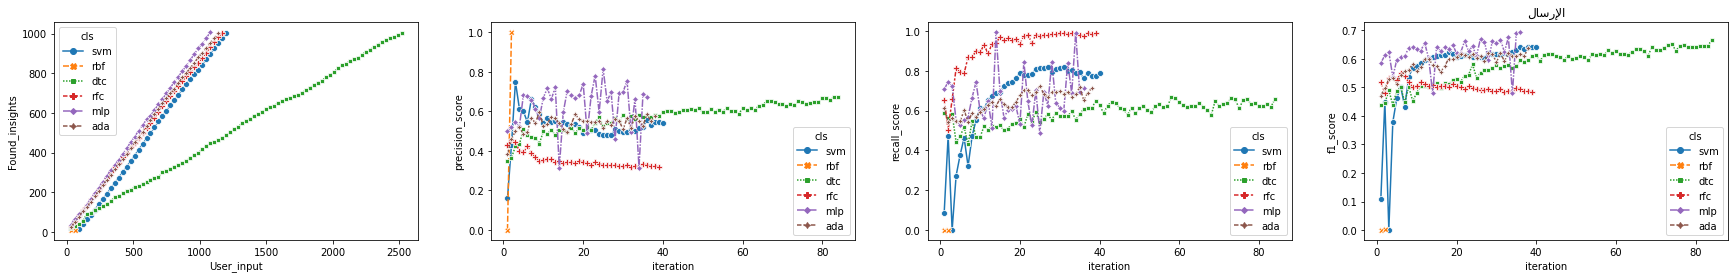

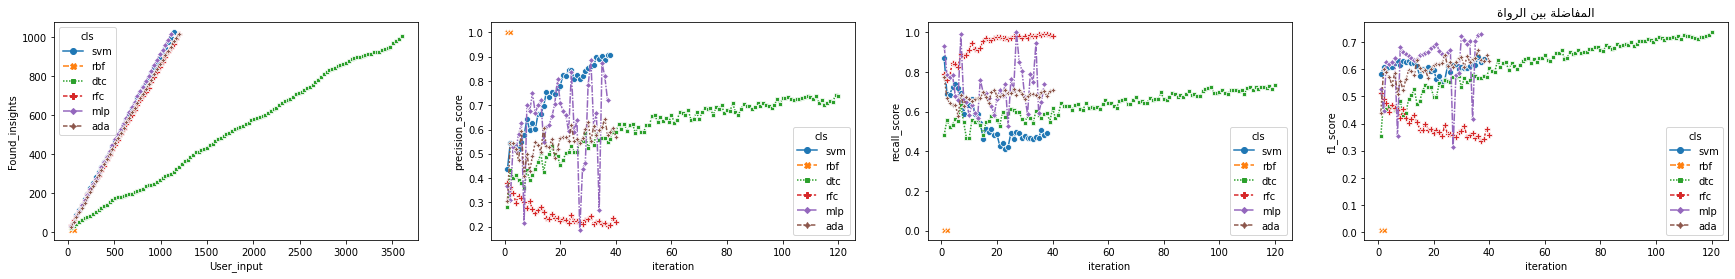

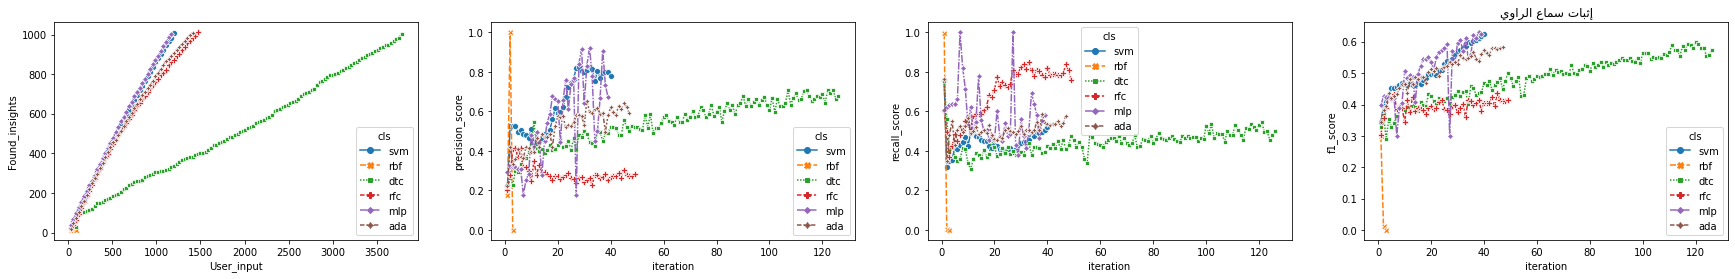

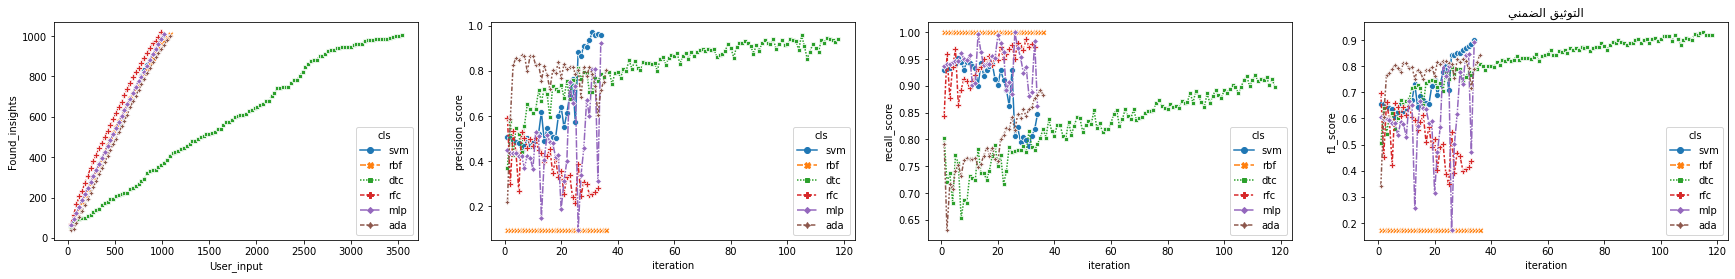

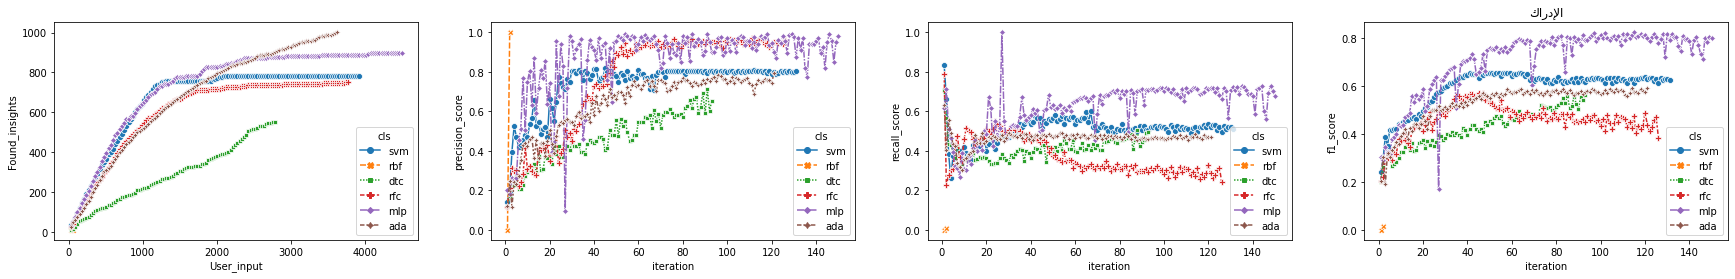

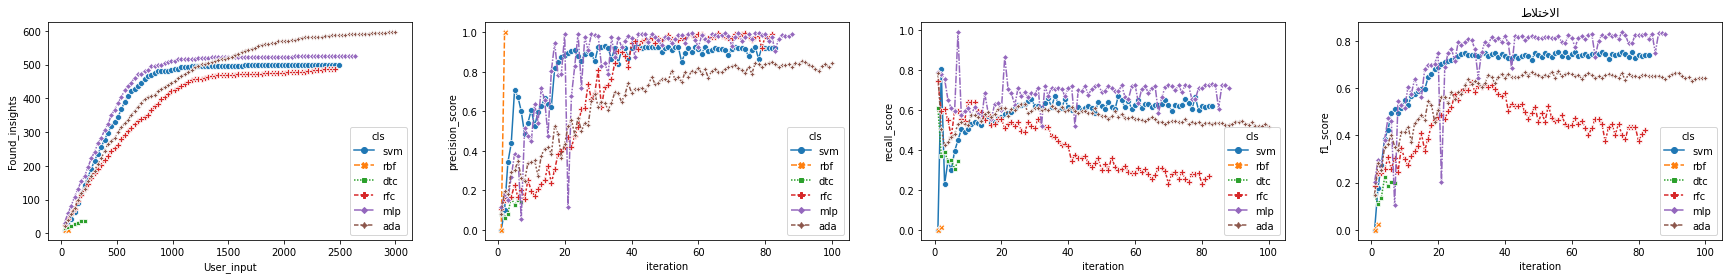

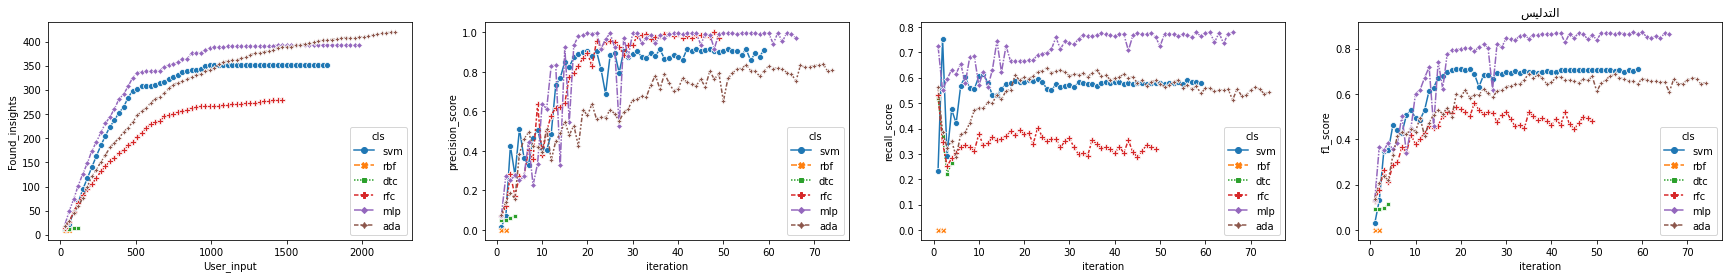

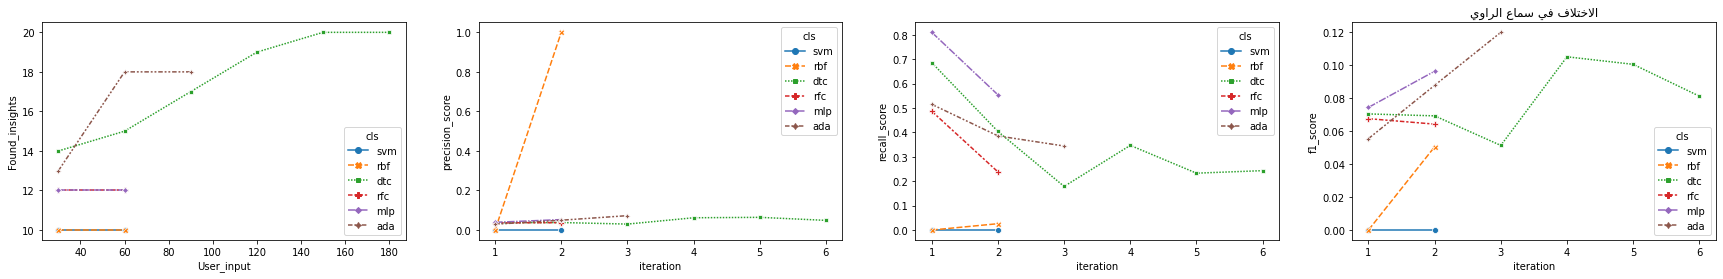

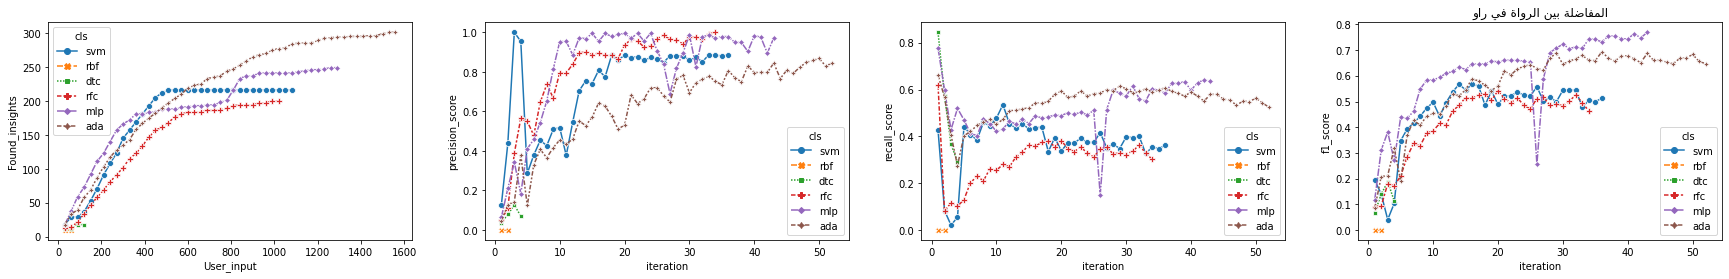

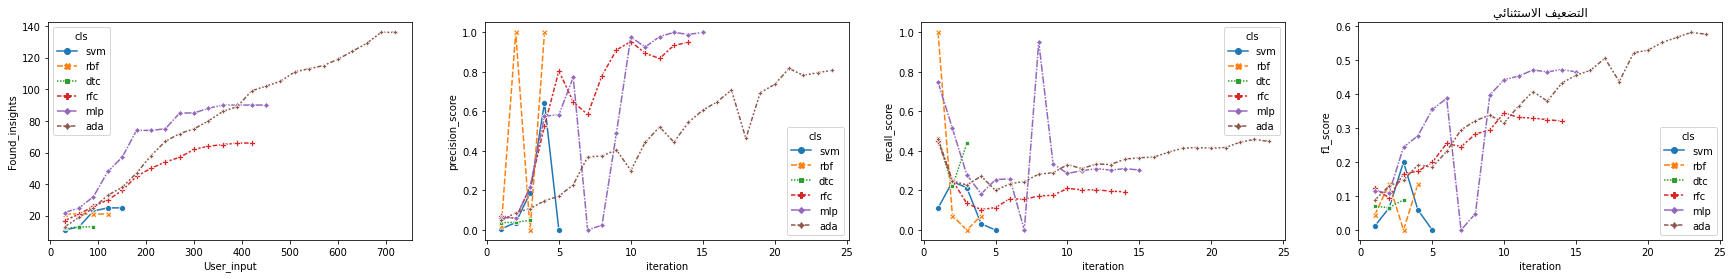

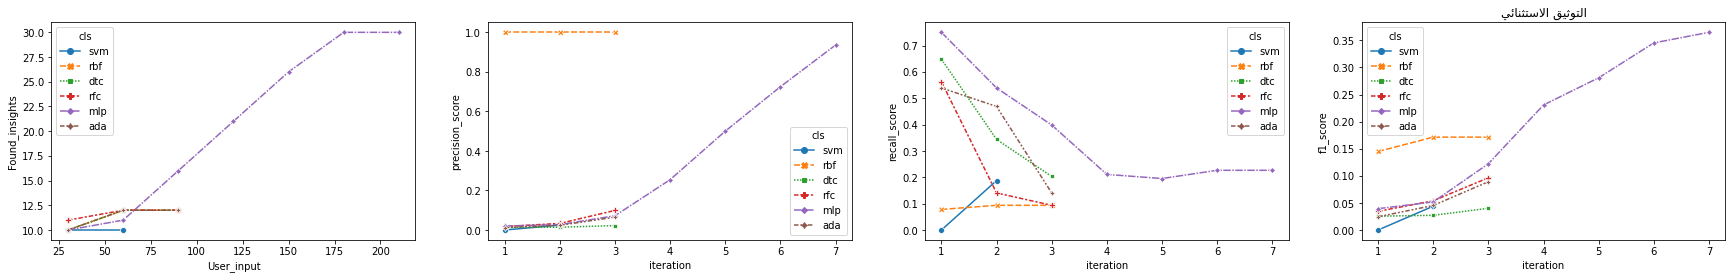

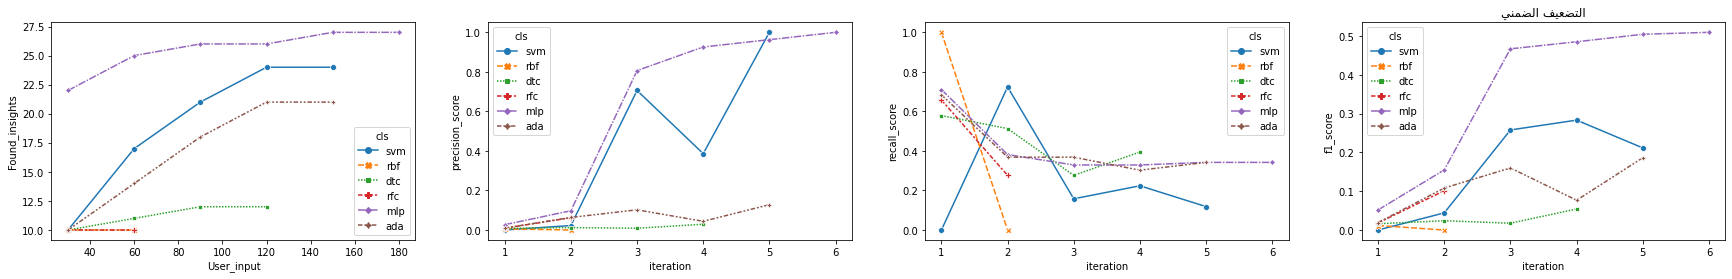

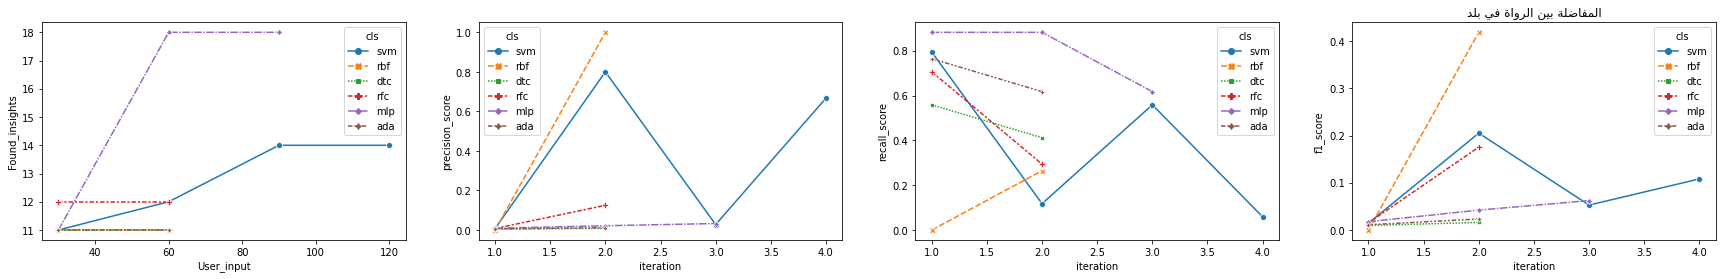

In [14]:
init_query_size = 10
adaptation_size = 30
prob_threshold = 0.5
precision_halt = 0.2

categories = list(df_corpus.columns)[2:15]
scores = {}

corpus = np.vstack(df_corpus['emeddings'].values)

#for each of the 10 categories
for k in range(len(categories)):
  labels = df_corpus[categories[k]] == 1
  scores[categories[k]] = []

  ##Generate initial query random
  init_white_list = get_initial_query(df_corpus, categories[k], init_query_size, True)
  init_black_list = get_initial_query(df_corpus, categories[k], init_query_size, False)

  for cls in classifiers:
    model = classifiers[cls]
    white_list = init_white_list #True Positive
    black_list = init_black_list #False Positive
    prev_white = black_list

    iteration = 0

    ##While more was discovered
    while len(df_corpus[white_list]) <1000 and (any(white_list != prev_white) or len(df_corpus[white_list])/(iteration*adaptation_size) > precision_halt):
      iteration += 1
      ###Adapt:reveal labels
      query_x = df_corpus[white_list | black_list]['emeddings']
      query_y = df_corpus[white_list | black_list][categories[k]]

      ###fit models
      model.fit(np.vstack(query_x.values), query_y.values)

      ###generate instances: pred on all corpus sentences
      pred_prob = model.predict_proba(corpus)[:,1]
      pred = pred_prob > 0.5
      df_corpus['pred'] = pred_prob

      ###rank top predected (map sentences score to biographies, to score narrator)
      rank = df_corpus['pred'] > prob_threshold
      filter_unseen = rank & (~(white_list | black_list))
      top_pred = df_corpus[filter_unseen].nlargest(adaptation_size, 'pred')
      adapt = df_corpus['text'].isin(top_pred['text'])

      ###score: update whitelists and blacklists
      prev_white = white_list
      white_list = white_list | (adapt & labels)
      black_list = black_list | (adapt & ~labels)

      scores[categories[k]].append({'cls': cls, 
                                    'iteration': iteration, 
                                    'User_input': iteration*adaptation_size, 
                                    'Found_insights': len(df_corpus[white_list]), 
                                    'precision_score': precision_score(labels, pred, average='binary'),
                                    'recall_score': recall_score(labels, pred, average='binary'), 
                                    'f1_score': f1_score(labels, pred, average='binary')})
      
      print('---------- Insights: '+categories[k]+', Classifier: '+cls+', Iteration: '+str(iteration)+' ----------')
      print(df_corpus[white_list & ~prev_white]['text'])
      print()
    
    
    ### save classifier model
    #classifiers[cls] = model#make_pipeline(vectorizer, model)
plot_measures(scores, categories)

In [15]:
df_corpus[white_list]

,Unnamed: 0,text,الإرسال,المفاضلة بين الرواة,إثبات سماع الراوي,التوثيق الضمني,الإدراك,الاختلاط,التدليس,الاختلاف في سماع الراوي,المفاضلة بين الرواة في راو,التضعيف الاستثنائي,التوثيق الاستثنائي,التضعيف الضمني,المفاضلة بين الرواة في بلد,clean,emeddings,pred
2141,484199,وكان أسند من بقي بدمشق,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[0.254754275, -0.0300743692, -0.0894792899, -0...",0.500000
2221,30040,وقال الفضل بن زياد عن أحمد : ليس أحد أروى لحدي...,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[0.279569477, -0.292848736, 0.0161610004, -0.0...",0.817996
8065,29798,وقد سمع إسماعيل من شرحبيل,0,0,1,0,0,0,0,0,0,0,0,0,1,False,"[0.474687576, -0.17808269, -0.105223067, -0.33...",0.813826
8822,299352,وقال أبو عروبة : ما رأيت بالبصرة أثبت من أبي م...,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[0.0213532336, -0.19555077, -0.122601748, -0.0...",0.820257
9482,50147,وقال إسحاق بن سيار النصيبي : ليس بالشام رجل هو...,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[0.15610911, -0.194127336, -0.0410415381, 0.08...",0.818689
10780,293696,حدثنا عبد الرحمن ، نا إبراهيم بن مسعود الهمذان...,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[0.1194112, -0.387697726, -0.136229604, 0.0635...",0.806318
11449,438229,وكان أسند من بقي بدمشق,0,0,1,0,0,0,0,0,0,0,0,0,0,False,"[0.254754275, -0.0300743692, -0.0894792899, -0...",0.500000
11520,487894,مسند وقته بمصر,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[0.172969192, 0.0200488232, 0.177428156, -0.15...",0.809459
12155,249124,قال عاصم بن بهدلة عن أبي وائل : ما اشتملت همدا...,0,1,0,0,0,0,0,0,0,0,0,0,1,False,"[0.189644456, -0.202888817, -0.118442833, -0.3...",0.809382
12298,231173,قال جعفر الطيالسي ، عن ابن معين : علي بن الجعد...,0,0,0,0,0,0,0,0,0,0,0,0,1,False,"[-0.0463209562, -0.220665976, 0.0129475454, 0....",0.813202


In [16]:
#lime
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

In [17]:
'''
idx = 6590
cat = 0
cls = 'svm'
explainer = LimeTextExplainer(class_names=[categories[cat],"Clean"])


exp = explainer.explain_instance(df_corpus.iat[idx], mypred, num_features=6)
exp.show_in_notebook(text=True)
'''

'\nidx = 6590\ncat = 0\ncls = \'svm\'\nexplainer = LimeTextExplainer(class_names=[categories[cat],"Clean"])\n\n\nexp = explainer.explain_instance(df_corpus.iat[idx], mypred, num_features=6)\nexp.show_in_notebook(text=True)\n'

In [18]:
#confusion matrix

#Experiment Quesions:

###Results:
* Which tags are suitable for this? Based in the amount of data that is available for the tag
* Does the initial grain size play a role in the overall performance 
* What is the best simple classifier

###Evaluation:
* Repeating the experiment and taking an average with error margin 
* Is this recall deriven vs f1 
* Average  recall jumps vs iterations
* Penalize for having a lower-score on true cases

###Model parameters:
* The effect of dimension reduction - umap-learn
* Using sophisticated bert with little data
* Kitchen sink approach
* Mix and match based on best performance
* Classifier hyper parameter search / similarity to choose
* What threshold to filter

###Embedding effects:
* Embedding padding
* word2vec vs Tfidf 
* farasa effect or tokenization of arabert

###Problem Design:
* Do we filter based on narrator biography or sentence
* Adaptive filtering litrature and trec batch filtering
* Number of iteration before halt vs no new vs poor persicion
* What are the assumptions 

###Production:
* Create interactive ui that is used for scenarios 
* How is google learns based on user interaction